In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.constants as aconst
import scipy.constants as const
from pycbc import psd as psd_func
from pycbc.filter.matchedfilter import sigma
from pycbc.psd import aLIGOZeroDetHighPower
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from simple_pe.waveforms import make_waveform, orthonormalize_modes, generate_eccentric_waveform, shifted_e

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


In [2]:
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/32, 10, (32*1028)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=6, orthonormalize_ecc_harms=False)
q = q_from_eta(params['symmetric_mass_ratio'])
m_total = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], q))
wf, _ = generate_eccentric_waveform(
    m_total, q, params['ecc10'], params['chi_eff'], params['chi_eff'], 5, 1028,
    f_ref_e=10, tlen=128, taper=False, to_fs=True
)
harms_ts = {k: harms[k].to_timeseries() for k in harms.keys()}

2025-11-27  15:23:10 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-11-27  15:23:10 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default


In [3]:
# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 1028
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

_, _, ovlps = orthonormalize_modes(harms, psd['H1'], 10, [0,1,-1,2], [0])
for k in ovlps.keys():
    print(f'{k}: {np.abs(ovlps[k])}')

0: 1
1: 0.4743226515353653
-1: 0.7543444890872693
2: 0.5545153316334462


Text(0.5, 0, 'Frequency / Hz')

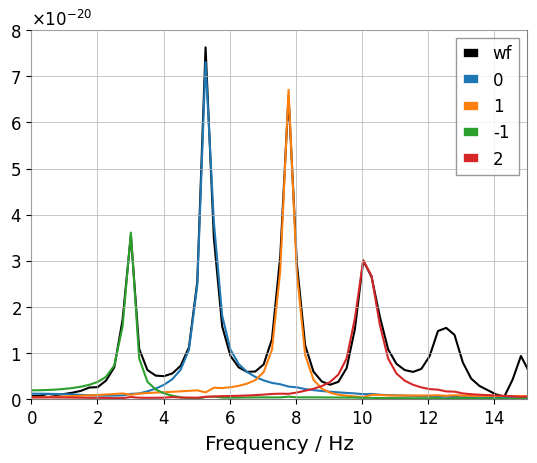

In [4]:
wf_ts = wf.to_timeseries()
wf_short = wf_ts[:4096*1].to_frequencyseries()
plt.plot(wf_short.sample_frequencies, np.abs(wf_short), c='k', label='wf')
for k in harms.keys():
    harm_short = harms_ts[k][:4096*1].to_frequencyseries()
    plt.plot(harm_short.sample_frequencies, np.abs(harm_short), label=str(k))
plt.xlim(0, 15)
plt.ylim(0,)
plt.legend()
plt.xlabel('Frequency / Hz')

In [5]:
# Calculates semi-major axis of orbit using Kepler's third law
def a_from_P(P, M):
    a_cubed = (const.G*M*P**2)/(4*np.pi**2)
    return a_cubed**(1/3)

# Calculates periastron advance for one orbital revolution
def peri_advance_orbit(P, e, M):
    numerator = 6*np.pi*const.G*M
    a = a_from_P(P, M)
    denominator = const.c**2*a*(1-e**2)
    return numerator/denominator

# Gets azimuthal frequency from gravitational wave frequency
def f_az(f_gw):
    return f_gw/2

# Gets radial frequency from gravitational wave frequency
def f_rad(f_gw, f_ref, ecc, M):
    P_az = 1/f_az(f_gw)
    e = shifted_e(f_gw, f_ref, ecc)
    peri_advance_per_orb = peri_advance_orbit(P_az, e, M*aconst.M_sun.value)
    P_rad = P_az*2*np.pi/peri_advance_per_orb
    return 1/P_az - 1/P_rad

Text(0, 0.5, 'Frequency / Hz')

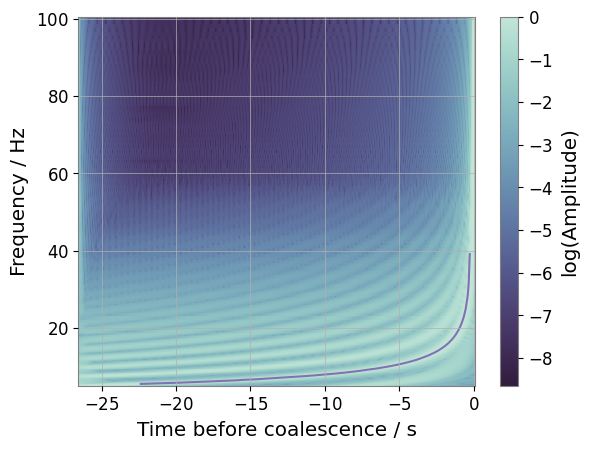

In [6]:
# Perform qtransform
h_q_times, h_q_freqs, h_q_plane = wf_ts.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(5, 100))
h_q_amp = h_q_plane**0.5

# Normalise amplitude at each freq
h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T

# Cut times
h_q_amp = h_q_amp[:, h_q_times<=0.1]
h_q_times = h_q_times[h_q_times<=0.1]

# Get evolution of f_gw by maximum power at each timestep
t_arr = h_q_times[2000:-25:10]
f_gw = h_q_freqs[np.argmax(h_q_amp, axis=0)[2000:-25:10]]
f_gw = np.convolve(f_gw, np.ones(31), "valid")/31
t_arr = t_arr[15:-15]

# Plot qtransform
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr, f_gw, c='m')

# Plot formatting
# plt.ylim(5,100)
# plt.xlim(-25, 0)

plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

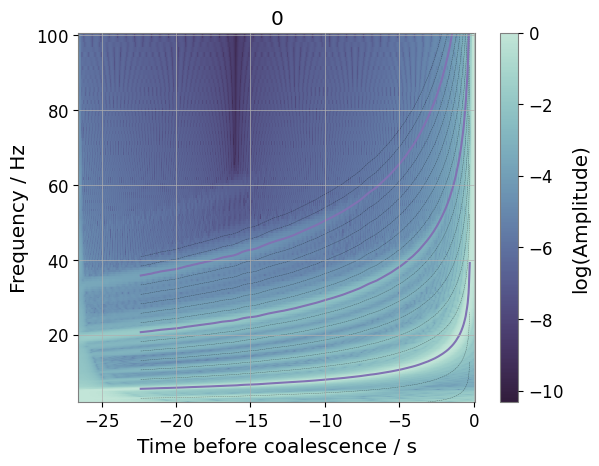

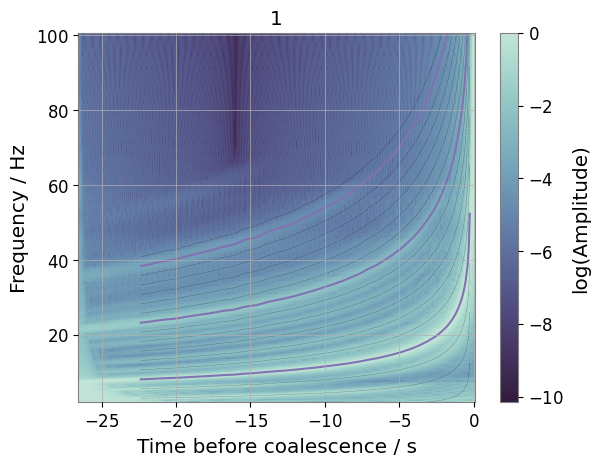

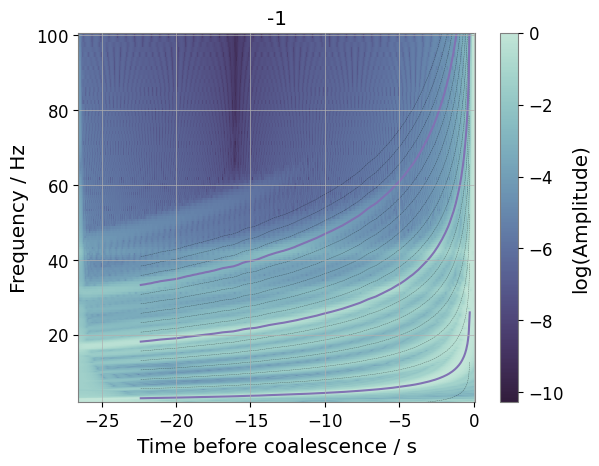

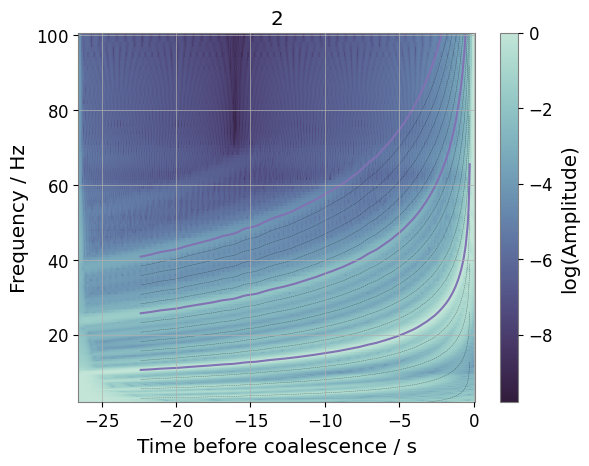

In [7]:
# Calculate azimuthal and radial frequency
f_azs = f_az(f_gw)
f_rads = f_rad(f_gw, 10, params['ecc10'], m_total)

for k in harms_ts.keys():
    
    #Perform qtransform
    h_q_times, h_q_freqs, h_q_plane = harms_ts[k].real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(2, 100))
    h_q_amp = h_q_plane**0.5
    
    # Normalise amplitude at each freq
    h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T

    # Cut times
    h_q_amp = h_q_amp[:, h_q_times<=0.1]
    h_q_times = h_q_times[h_q_times<=0.1]
    
    # Plot qtransform
    cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
    plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), cmap=cmap)
    plt.colorbar(label='log(Amplitude)')

    # Plot harmonic frequencies
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    for i in range(-2, 15):
        plt.plot(t_arr, 2*f_azs + i*f_rads, c='k', lw=0.3, ls='dashed', alpha=0.5)
    for i in range(3):
        plt.plot(t_arr, 2*f_azs + (k+6*i)*f_rads, c='m')
    
    # Plot formatting
    plt.ylim(ylims)
    plt.xlim(xlims)
    plt.xlabel('Time before coalescence / s')
    plt.ylabel('Frequency / Hz')
    plt.title(str(k))
    plt.show()

In [41]:
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/32, 10, (32*4096)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=6, orthonormalize_ecc_harms=False)
harms_ts = {k: harms[k].to_timeseries() for k in harms.keys()}
harms_on = make_waveform(params, 1/32, 10, (32*4096)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=6, orthonormalize_ecc_harms=True)
harms_on_ts = {k: harms_on[k].to_timeseries() for k in harms_on.keys()}

2025-11-27  14:36:01 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-11-27  14:36:01 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2025-11-27  14:36:15 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-11-27  14:36:15 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default


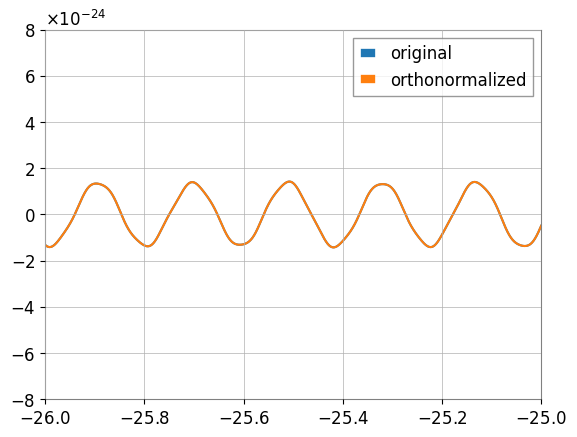

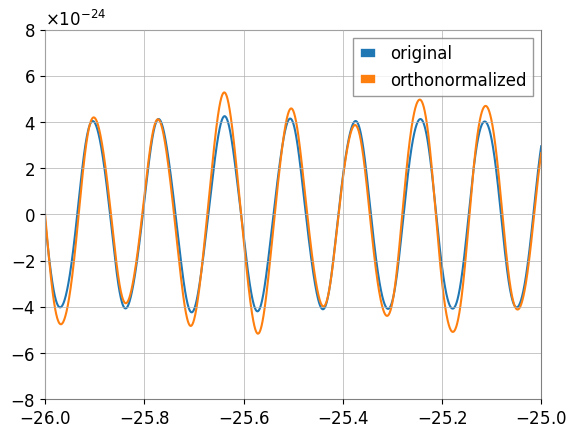

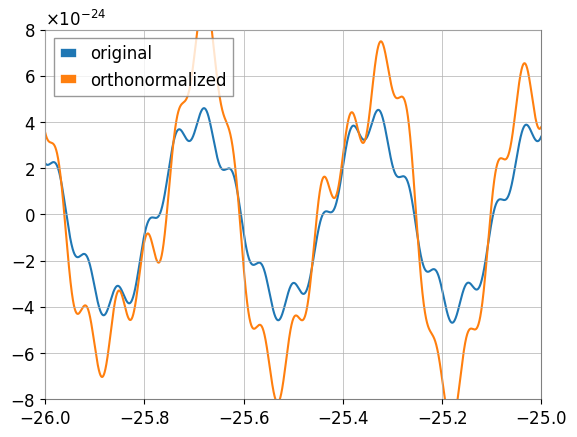

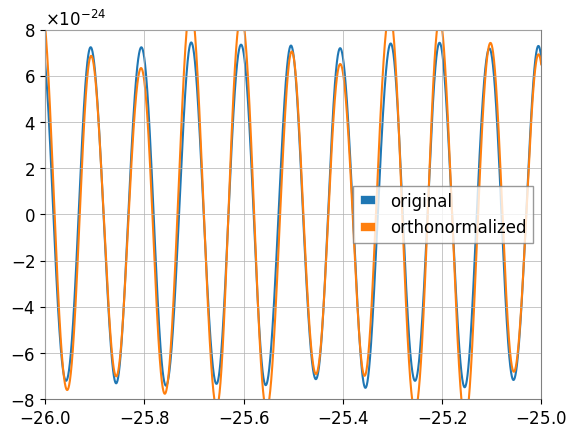

In [42]:
delta_f = 1.0 / 32
flen = int(32*4096)//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, 10)
for k in harms_ts.keys():
    wf_sigma = sigma(harms_ts[k], psd, low_frequency_cutoff=10, high_frequency_cutoff=psd.sample_frequencies[-1])
    plt.plot(harms_ts[k].sample_times, harms_ts[k]/wf_sigma, c='C0', label='original')
    plt.plot(harms_on_ts[k].sample_times, harms_on_ts[k], c='C1', label='orthonormalized')
    plt.xlim(-26,-25)
    plt.ylim(-0.8e-23, 0.8e-23)
    plt.legend()
    plt.show()

# Before phase improvement (DO NOT RERUN UNLESS ON OLD SIMPLE_PE BRANCH)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.constants as aconst
import scipy.constants as const
from pycbc import psd as psd_func
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from simple_pe.waveforms import make_waveform, orthonormalize_modes, generate_eccentric_waveform, shifted_e

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


In [13]:
params = {'ecc10': 0.2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
harms = make_waveform(params, 1/32, 10, (32*1028)//2 + 1, approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4, n_ecc_gen=6, orthonormalize_ecc_harms=False)
q = q_from_eta(params['symmetric_mass_ratio'])
m_total = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], q))
wf, _ = generate_eccentric_waveform(
    m_total, q, params['ecc10'], params['chi_eff'], params['chi_eff'], 5, 1028,
    f_ref_e=10, tlen=128, taper=False, to_fs=True
)
harms_ts = {k: harms[k].to_timeseries()[:32*1028] for k in harms.keys()}
harms = {k: harms_ts[k].to_frequencyseries() for k in harms_ts.keys()}

2025-11-26  14:54:11 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2025-11-26  14:54:11 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default


In [14]:
# Generate psd
ifos = ['H1']
tlen = 32
sample_rate = 1028
f_low = 10
psds = {'H1': 'aLIGO175MpcT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

short_harms = {k: harms[k][:512] for k in harms.keys()}
print(orthonormalize_modes(harms, psd['H1'], 10, [0,1,-1], [0]))

({0: <pycbc.types.frequencyseries.FrequencySeries object at 0x7fc97fb90cd0>, 1: <pycbc.types.frequencyseries.FrequencySeries object at 0x7fc982f49660>, -1: <pycbc.types.frequencyseries.FrequencySeries object at 0x7fc98331b880>}, {0: 30161.26191841121, 1: 8041.531597023146, -1: 3644.047865490114}, {0: 1, 1: (-0.18023730730822168+0.051197700565332606j), -1: (0.3704709938394857-0.047325528506429966j)})


Text(0.5, 0, 'Frequency / Hz')

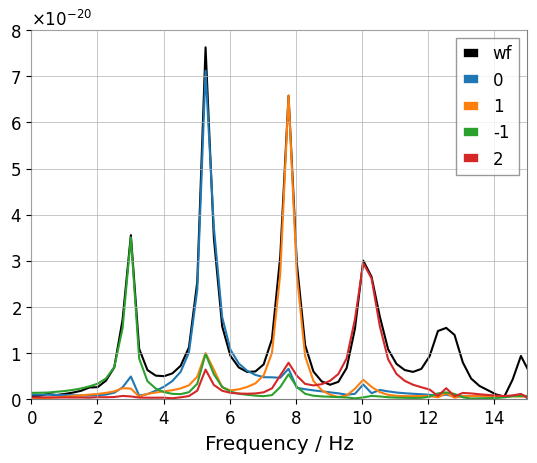

In [15]:
wf_ts = wf.to_timeseries()
wf_short = wf_ts[:4096*1].to_frequencyseries()
plt.plot(wf_short.sample_frequencies, np.abs(wf_short), c='k', label='wf')
for k in harms.keys():
    harm_short = harms_ts[k][:4096*1].to_frequencyseries()
    plt.plot(harm_short.sample_frequencies, np.abs(harm_short), label=str(k))
plt.xlim(0, 15)
plt.ylim(0,)
plt.legend()
plt.xlabel('Frequency / Hz')

In [16]:
# Calculates semi-major axis of orbit using Kepler's third law
def a_from_P(P, M):
    a_cubed = (const.G*M*P**2)/(4*np.pi**2)
    return a_cubed**(1/3)

# Calculates periastron advance for one orbital revolution
def peri_advance_orbit(P, e, M):
    numerator = 6*np.pi*const.G*M
    a = a_from_P(P, M)
    denominator = const.c**2*a*(1-e**2)
    return numerator/denominator

# Gets azimuthal frequency from gravitational wave frequency
def f_az(f_gw):
    return f_gw/2

# Gets radial frequency from gravitational wave frequency
def f_rad(f_gw, f_ref, ecc, M):
    P_az = 1/f_az(f_gw)
    e = shifted_e(f_gw, f_ref, ecc)
    peri_advance_per_orb = peri_advance_orbit(P_az, e, M*aconst.M_sun.value)
    P_rad = P_az*2*np.pi/peri_advance_per_orb
    return 1/P_az - 1/P_rad

Text(0, 0.5, 'Frequency / Hz')

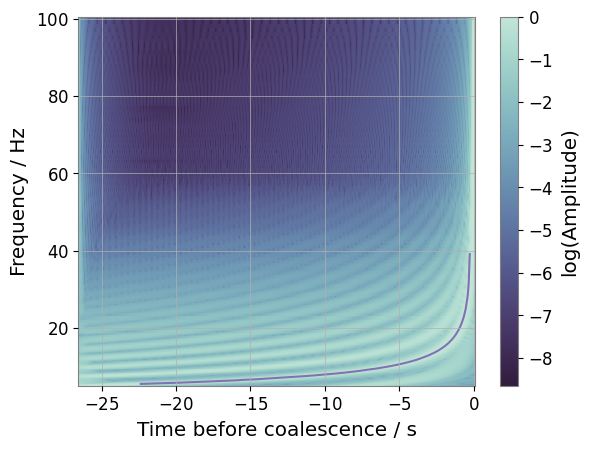

In [17]:
# Perform qtransform
h_q_times, h_q_freqs, h_q_plane = wf_ts.real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(5, 100))
h_q_amp = h_q_plane**0.5

# Normalise amplitude at each freq
h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T

# Cut times
h_q_amp = h_q_amp[:, h_q_times<=0.1]
h_q_times = h_q_times[h_q_times<=0.1]

# Get evolution of f_gw by maximum power at each timestep
t_arr = h_q_times[2000:-25:10]
f_gw = h_q_freqs[np.argmax(h_q_amp, axis=0)[2000:-25:10]]
f_gw = np.convolve(f_gw, np.ones(31), "valid")/31
t_arr = t_arr[15:-15]

# Plot qtransform
cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), cmap=cmap)
plt.colorbar(label='log(Amplitude)')

# Plot frequency track
plt.plot(t_arr, f_gw, c='m')

# Plot formatting
# plt.ylim(5,100)
# plt.xlim(-25, 0)

plt.xlabel('Time before coalescence / s')
plt.ylabel('Frequency / Hz')

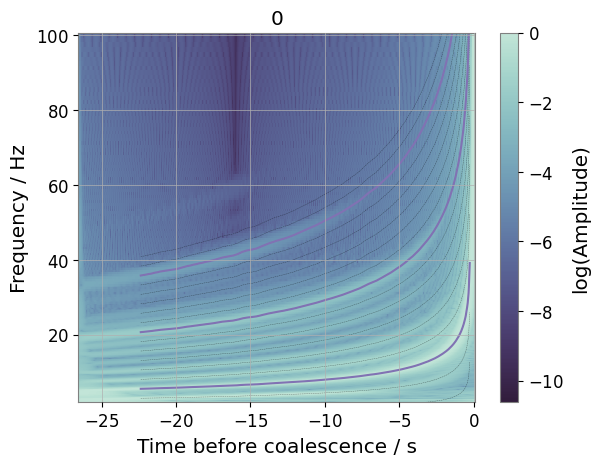

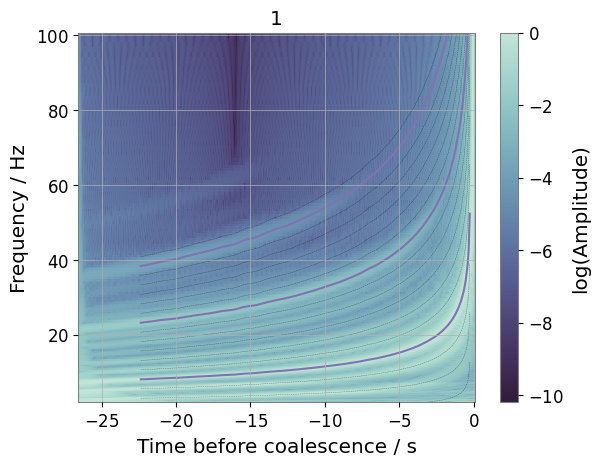

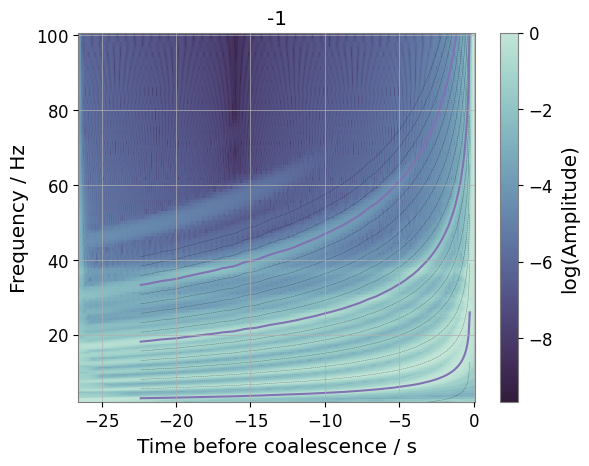

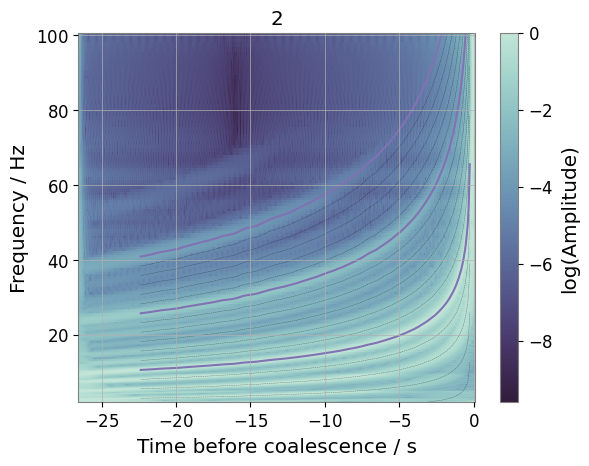

In [18]:
# Calculate azimuthal and radial frequency
f_azs = f_az(f_gw)
f_rads = f_rad(f_gw, 10, params['ecc10'], m_total)

for k in harms_ts.keys():
    
    #Perform qtransform
    h_q_times, h_q_freqs, h_q_plane = harms_ts[k].real().qtransform(1/512, logfsteps=300, qrange=(50,50), frange=(2, 100))
    h_q_amp = h_q_plane**0.5
    
    # Normalise amplitude at each freq
    h_q_amp = (h_q_amp.T / np.max(h_q_amp, axis=1)).T

    # Cut times
    h_q_amp = h_q_amp[:, h_q_times<=0.1]
    h_q_times = h_q_times[h_q_times<=0.1]
    
    # Plot qtransform
    cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
    plt.pcolormesh(h_q_times, h_q_freqs, np.log10(h_q_amp), cmap=cmap)
    plt.colorbar(label='log(Amplitude)')

    # Plot harmonic frequencies
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    for i in range(-2, 15):
        plt.plot(t_arr, 2*f_azs + i*f_rads, c='k', lw=0.3, ls='dashed', alpha=0.5)
    for i in range(3):
        plt.plot(t_arr, 2*f_azs + (k+6*i)*f_rads, c='m')
    
    # Plot formatting
    plt.ylim(ylims)
    plt.xlim(xlims)
    plt.xlabel('Time before coalescence / s')
    plt.ylabel('Frequency / Hz')
    plt.title(str(k))
    plt.show()